
#Work 3 Hybrid Summarization with SumBasic and Pegasus-large Out-of-the-Box

Prior to this worksheet the full organic chemistry patents from HUPD were condensed using extractive summarization (SumBasic technique). We now try to form better summaries with Pegasus-large.

## Setup

In [ ]:
#install libraries
!pip install -q datasets
!pip install -q transformers
!pip install --quiet --upgrade accelerate
!pip install -q sentencepiece
!pip install -q evaluate
!pip install -q rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# Install Packages

#standard data science libraries
import pandas as pd
import numpy as np
import random
import matplotlib

#visualization
import matplotlib.pyplot as plt
from pprint import pprint
from IPython.display import display, HTML

#datasets
import datasets
from datasets import load_from_disk
from datasets import load_dataset, load_metric
#transformers
#from transformers import AutoTokenizer
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import shutil #to save cached data to Drive

# PyTorch
import torch
from torch.utils.data import DataLoader

#rouge
import evaluate

In [ ]:
# This cell will authenticate you and mount your Drive in the Colab.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
save_dir="/content/drive/MyDrive/W266/HUPD"

Mounted at /content/drive


##Load Data

In [ ]:
extracted_train = load_from_disk(save_dir + '/extracted_train_sample')

In [ ]:
extracted_train

Dataset({
    features: ['patent_number', 'decision', 'title', 'abstract', 'cpc_label', 'ipc_label', 'filing_date', 'patent_issue_date', 'date_published', 'examiner_id', 'extractive_summaries'],
    num_rows: 720
})

## Tinker with it:

In [ ]:
# Print info about the sizes of the train and validation sets
print(f'Train dataset size: {dataset_dict["train"].shape}')
print(f'Validation dataset size: {dataset_dict["validation"].shape}')

Train dataset size: (56, 14)
Validation dataset size: (0, 14)


In [ ]:
#prepare training and validation sets
train_set = dataset_dict['train']
val_set = dataset_dict['validation']

We review the data to make some initial observations:



In [ ]:
train_set

Dataset({
    features: ['patent_number', 'decision', 'title', 'abstract', 'claims', 'background', 'summary', 'description', 'cpc_label', 'ipc_label', 'filing_date', 'patent_issue_date', 'date_published', 'examiner_id'],
    num_rows: 56
})

Average abstract length:  120
Average claims length:  891
Average background length:  458
Average summary length:  699
Average description length:  7529


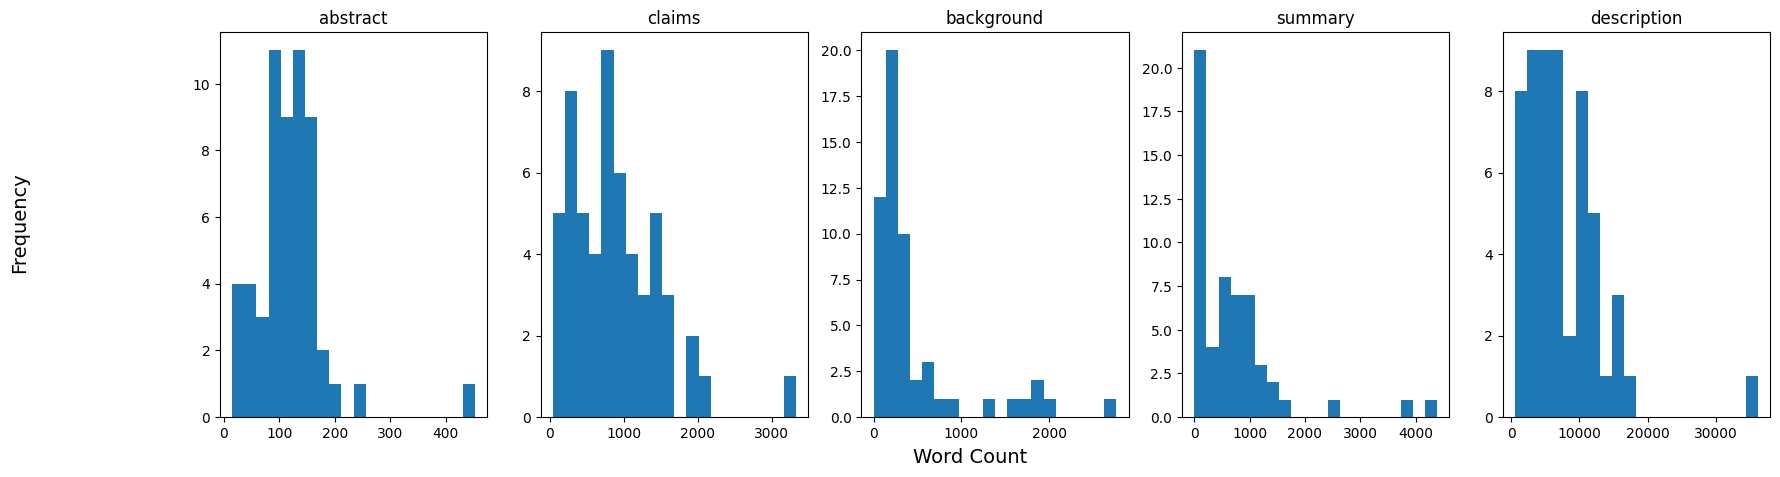

In [ ]:
plot_sections = ['abstract', 'claims', 'background', 'summary', 'description']
num_subplots = len(plot_sections)
fig, axes = plt.subplots(1, num_subplots, figsize = (20,5))
for i in range(num_subplots):
  section = plot_sections[i]
  section_length = [len(train_set[section][i].split()) for i in range(len(train_set[section]))]
  axes[i].hist(section_length, bins = 20)
  axes[i].set_title(section)
fig.supylabel('Frequency', fontsize=14)
fig.supxlabel('Word Count', fontsize=14)

#check the average length of every section
for section in ['abstract', 'claims', 'background', 'summary', 'description']:
    section_length = [len(train_set[section][i].split()) for i in range(len(train_set[section]))]
    # Calculate the average length
    average_length = sum(section_length) / len(section_length)
    print(f'Average {section} length: {average_length: .0f}')

## Summarizing Extractive Summaries with Pegasus-large


In [ ]:
#specify base model
model_name = "google/pegasus-large"

#specify compute device (GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"

#specify tokenizer
tokenizer = PegasusTokenizer.from_pretrained(model_name)

#instantiate model
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(device)

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.09k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

In [ ]:
#create a function to tokenize the data
def tokenize_input(input,column_name):
    tokenized = tokenizer(input[column_name], truncation=True, padding='max_length', return_tensors="pt") #.to(device)
    tokenized['input_ids'] = tokenized['input_ids'].squeeze()
    tokenized['attention_mask'] = tokenized['attention_mask'].squeeze()
    return tokenized

In [ ]:
# Tokenize training set
tokenized_input = extracted_train.map(lambda obs: tokenize_input(obs,'extractive_summaries'))

Map:   0%|          | 0/720 [00:00<?, ? examples/s]

In [ ]:
#set format to Torch
tokenized_input.set_format(type='torch', columns=['input_ids', 'attention_mask']) #device = device to load the torch formatted tensors to your GPU.

#set up DataLoader
batch_size = 5 #note that the standard batch size for the DataLoader is 200
train_dataloader = DataLoader(tokenized_input, batch_size = batch_size) #num_workers = 4 << increase if you need higher speed.


In [ ]:
summarized_texts = []
for batch in iter(train_dataloader):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    summary = model.generate(input_ids = input_ids,
                             attention_mask = attention_mask,
                             max_length = 150
                             )
    summarized_text = tokenizer.batch_decode(summary, skip_special_tokens=False)
    summarized_texts.extend(summarized_text)

In [ ]:
#Generate Rouge Scores
rouge = evaluate.load('rouge')
predictions = summarized_texts
references = tokenized_input['abstract']
results = rouge.compute(predictions=predictions,
                        references=references)
print(results)

{'rouge1': 0.2300565358596009, 'rouge2': 0.08827813925523956, 'rougeL': 0.16066385096320834, 'rougeLsum': 0.1605809891504077}


In [ ]:
num_examples = 5

# Randomly sample example paies
sampled_summarized_texts = [summarized_texts[i] for i in random_indices]
sampled_abstracts = [extracted_train['abstract'][i] for i in random_indices]

# Zip the lists together
comparisons = list(zip(sampled_summarized_texts, sampled_abstracts))

# Create a pandas DataFrame from the zipped lists
comparison_df = pd.DataFrame(comparisons, columns=['predicted_summary', 'abstract'])

# Display df
display(HTML(comparison_df.to_html()))

,predicted_summary,abstract
0,"<pad>A “neonatal NIF-related peptide” or “nNRP” is defined herein as a Cancer-Associated SCM-Recognition, Immune Defense Suppression, and Serine Protease Protection Peptide (CRISPP) which is naturally occurring in humans; A1ATmomycin, which has been shown to inhibit NET formation; and other nNIF-related peptides; and as analogs of naturally occurring forms of nNRPs that inhibit NETosis and/or the formation of NETs and are structurally altered, relative to a given human nNRP, by at least one amino acid addition, pre-treated deletion, substitution, or by incorporation of one or more amino acids with a blocking group. These results demonstrate that NET-inhibitory peptides</s>","An isolated and purified peptide, neonatal NET-inhibitory Factor (nNIF), is disclosed. Methods for treatment of and prophylaxis against inflammatory disorders are also disclosed, including methods of treatment of and prophylaxis against inflammatory disorders comprising administering NET-inhibitory peptides (NIPs), which may be a nNIF, a pharmaceutically acceptable salt of a nNIF, a nNIF analog, a pharmaceutically acceptable salt of a nNIF analog, a nNIF-Related Peptide (nNRP), including the nNRP, Cancer-Associated SCM-Recognition, Immune Defense Suppression, and Serine Protease Protection Peptide (CRISPP), a pharmaceutically acceptable salt of a nNRP, a nNRP analog, or a pharmaceutically acceptable salt of a nNRP analog, to an individual."
1,"<pad>or lower, thereby obtaining products including a compound (3) represented by the following formula (3): (in formula (1), R1, R2, and R4 each independently are a hydrogen atom, a deuterium atom, or an alkyl group which has a carbon number of from 1 to 3 and may have been substituted with a halogen atom and/or a deuterium atom, R3 and R5 each independently are a hydrogen atom or a deuterium atom, and X is a chlorine atom, a fluorine atom, a bromine atom, or an iodine atom); R6—OR7 (2) (in formula (2), R6 is a hydrogen atom, a deuterium atom, an alkyl group which has a carbon</s>","The present invention relates to a method for producing an unsaturated-acid ester or an unsaturated acid, containing a step of reacting a compound (1) represented by the following formula (1) with a compound represented by the following formula (2) (excluding the compound (1)) in the presence of a Lewis acid catalyst at a temperature of the boiling point of the compound (1) or higher and 350° C. or lower, thereby obtaining products including a compound represented by the following formula (3): (in formula (1) and formula (3), R1, R2 and R4 each independently may be hydrogen atom or an alkyl group, R3 and R5 each independently are hydrogen atom or a deuterium atom, and X is a halogen atom; in formula (2) and formula (3), R6 may be hydrogen atom, an alkyl group or an aryl group, and R7 is hydrogen atom or a deuterium atom)."
2,"<pad>In some embodiments, HET(2) is a 5-membered heterocyclic ring having 1-3 heteroatom groups which are each independently N, NH, 0, or S, optionally having one group —C(<unk>O), and optionally having 1-3 double bonds. “Alkynyl” means carbon chains which contain at least one carbon-carbon triple bond, and which may be linear or branched or combinations thereof.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>","Compounds having the structure of Formula I, including pharmaceutically acceptable salts of the compounds, wherein X is —C(═O) or —S(O)2—, are CETP inhibitors and are useful for raising HDL-cholesterol, reducing LDL-cholesterol, and for treating or preventing atherosclerosis."
3,"<pad>The temperature and pressure conditions to be established at the particular stages, the number of stages and the p

*  Extractive sum actually did well on example 2 where we are describing a synthesis pathway, but the compound names seem to be stored in a list somewhere (compound 2, compound 3, ...) so we cannot directly discern the synthesis from the summary provided.
*  Further, we see references to things like "Formula 1" which indicates a formula listed somewhere in the document that isn't easily accessed by the model.
